<a href="https://colab.research.google.com/github/Megaptera666/Linearized-electrodiffusion/blob/master/Linearized_electrodiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Electrodiffusion of K<sup>+</sup> through small, tortuous extracellular spaces in the presence of K<sup>+</sup> sources and sinks
##Application of a linearized version of the Nernst-Plank equation


#Problem definition

<p>The brain is comprised of millions of neurons that incenssantly produce cognitive computations. Unlike in the cables and chips of man-made circuits, the electric signals underlying these computations are mediated by the flux of of ions such as K<sup>+</sup>. The number of ions required to carry electric currents is minute. However, in some cases, neurons are so densely packed that the extracellular concentration of K<sup>+</sup> ([K]<sub>o</sub>, in mol cm<sup>-3</sup>) is prone to change, making the regulation of [K]<sub>o</sub> a widespread challenge throughout the brain.

<p>This script calculates [K]<sub>o</sub> as a function of position in a two-dimentional space in the presence of K<sup>+</sup> sources and sinks and in the presence of an extracellular electric field. The script utilizes the numerical method of lines to calculate the rate of change in [K]<sub>o</sub>(x) (in mol cm <sup>-3</sup> s<sup>-1</sup>), as follows.

<p>The [continuity equation](https://en.wikipedia.org/wiki/Continuity_equation) dictates that, if the lateral flux of K<sup>+</sup> (J<sup>K</sup><sub>electrodiffusion</sub> (x) , in mol cm<sup>-2</sup> s<sup>-1</sup>) is not in balance with the sources or sinks of K<sup>+</sup> (Q<sub>s</sub>, in mol cm<sup>-3</sup> s<sup>-1</sup>), then [K]<sub>o</sub> (x) must be changing in time:
$
\begin{align}
\frac{\partial [K]_o(x)}{\partial t} &= -\frac{\partial J^K_{electrodiffusion}(x)}{\partial x} + Q_s(x) \tag{1}
\end{align}$

The [Nernst-plank equation](https://en.wikipedia.org/wiki/Nernst%E2%80%93Planck_equation) describes the flux of ions under the influence of both an ionic concentration gradient ($\frac{\partial [K]_o}{\partial x}$ in mol cm <sup>-2</sup>) and an electric field ($\frac{\partial Vo}{\partial x}$, in V cm <sup>-1</sup>)

$
\begin{align}
 J^K_{electrodiffusion}(x) =- D^* \bigg[\frac{\partial [K]_o}{\partial x} + r [K]_o \frac{\partial Vo}{\partial x} \bigg] \tag{2}
 \end{align}$

#Problem definition 

In [1]:
#@title Libraries {display-mode: "form"}
import numpy as np
import scipy.integrate as integrate
from numpy.core._multiarray_umath import ndarray
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc #This is to display the animation
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [128]:
#@title Geometry and time {display-mode: "form"}
#@markdown Total length [um]:
length_x =   100#@param{type:"number"} 
#@markdown delta x [um]:
delta_x = 0.1 #@param {type:"number"}
x_steps = round(length_x / delta_x)

#@markdown total time [ms]
tf = 200  #@param {type:"number"}
#@markdown delta t [ms]
delta_t = 1.  #@param {type:"number"}
nout = round(tf / delta_t)


In [144]:
#@title Physical properties {display-mode: "form"}
#@markdown #Tortuosity factor
lambda_ = 1.2 #@param {type:"number"}
#@markdown #Alpha factor
alpha_ =  1#@param {type:"number"}
#@markdown #Difussion coefficient of K in ringers [um^2 s-1]
Diffusion_coefficient = 2000  #@param {type:"number"} 

#@markdown Initial [K]o at x=0 [mM]
Ko_start =  3#@param {type:"number"} 
#@markdown Initial [K]o at  x=l [mM]
Ko_end = 3. #@param {type:"number"} 

#@markdown #Sources and sinks  <br/>
#@markdown magnitude [mM s-1]
source =   0#@param {type:"number"} 
sink =  0#@param {type:"number"} 

#@markdown location [um]
source_start = 0  #@param {type:"number"} 
source_end = 20  #@param {type:"number"}
sink_start =20  #@param {type:"number"} 
sink_end = 30  #@param {type:"number"} 

#@markdown #Voltage gradient  <br/>
#@markdown Magnitude at x=0 [mV]
V_start =  0#@param {type:"number"} 
#@markdown Magnitude at x=l [mV]
V_end =  1#@param {type:"number"} 

Faraday = 96485.33289  # [C mol - 1]
R_ = 8.314  # [J K−1 mol−1] universal gas constant
T = 310.15  # [K] 37 C in Kelvin
r = (Faraday / (R_ * T))  # [C / J]

#Problem instantiation

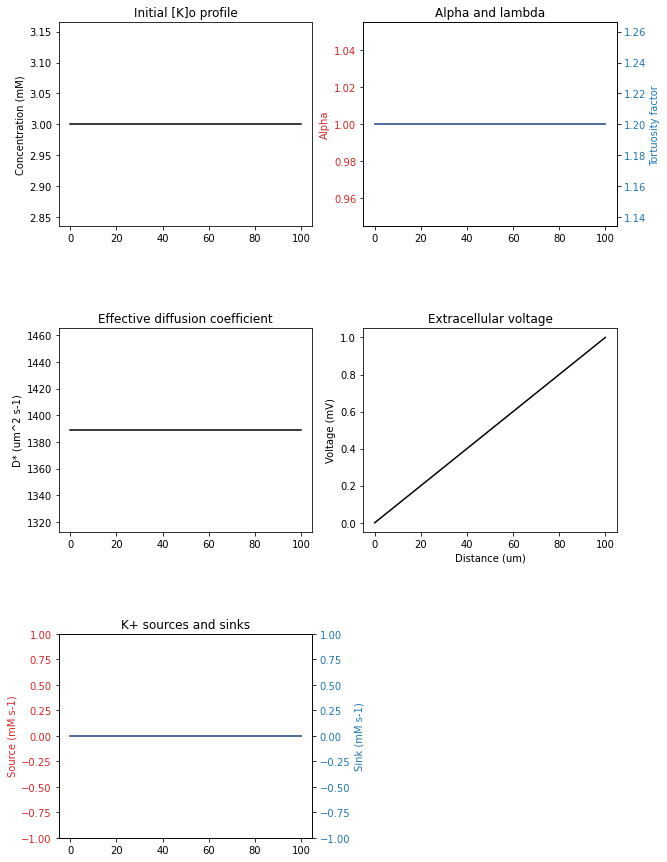

In [145]:
#@title Initial conditions
Initial_ko_x = np.zeros(x_steps)
Vo_x = np.zeros(x_steps)
SRS_alpha = np.zeros(x_steps)
SRS_tortuosity = np.zeros(x_steps)
D_x = np.zeros(x_steps)
source_x = np.zeros(x_steps)
sink_x = np.zeros(x_steps)
x_dim = np.linspace(0, length_x, x_steps)

# Parametrize initial concentration
Initial_ko_x[:] = np.linspace(Ko_start,Ko_end, x_steps)  # [mM]

# Parametrize SRS alpha
SRS_alpha.fill(alpha_)

# Parametrize tortuosity
SRS_tortuosity.fill(lambda_)

# Calculate effective diffusion coefficient
D_x[:] = Diffusion_coefficient / SRS_tortuosity[:] ** 2

# Parametrize Vo_x
Vo_x[:] = np.linspace(V_start,V_end, x_steps) #[mV]

# Calculate dVodx
dVodx = np.gradient(Vo_x, delta_x, edge_order=2) #[mV um-1]

# Parametrize sources and sinks
source_x[round(source_start/delta_x):round(source_end/delta_x)] = source  # [mM s-1]
# print(source_x)
sink_x[round(sink_start/delta_x):round(sink_end/delta_x)] = sink  # [mM s-1]

#plot initial conditions
fig = plt.figure(figsize=(10,15))
#Initial Ko concentration
Ax0 = fig.add_subplot(3, 2, 1)
Ax0.plot(x_dim,Initial_ko_x,color="k")
Ax0.set_title("Initial [K]o profile")
Ax0.set_ylabel("Concentration (mM)")
#Alpha 
Ax1 = fig.add_subplot(3, 2, 2)
color = 'tab:red'
Ax1.set_title("Alpha and lambda")
Ax1.set_ylabel("Alpha", color=color)
Ax1.plot(x_dim,SRS_alpha,color=color)
Ax1.tick_params(axis='y', labelcolor=color)
#Lambda
Ax2 = Ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
Ax2.set_ylabel('Tortuosity factor', color=color)  # we already handled the x-label with ax1
Ax2.plot(x_dim,SRS_tortuosity, color=color)
Ax2.tick_params(axis='y', labelcolor=color)
# Ax1.legend(loc='best')
#Effective diffusion coefficient
Ax3 = fig.add_subplot(3, 2, 3)
Ax3.plot(x_dim,D_x,color="k")
Ax3.set_title("Effective diffusion coefficient")
Ax3.set_ylabel("D* (um^2 s-1)")
#Effective diffusion coefficient
Ax4 = fig.add_subplot(3, 2, 4)
Ax4.plot(x_dim,Vo_x,color="k")
Ax4.set_title("Extracellular voltage")
Ax4.set_ylabel("Voltage (mV)")
#Sources and sinks
#Source
Ax5 = fig.add_subplot(3, 2, 5)
color = 'tab:red'
Ax5.set_title("K+ sources and sinks")
Ax5.set_ylabel("Source (mM s-1)", color=color)
Ax5.set_ylim(sink-1,source+1)
Ax5.plot(x_dim,source_x,color=color)
Ax5.tick_params(axis='y', labelcolor=color)
#Lambda
Ax6 = Ax5.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
Ax6.set_ylabel('Sink (mM s-1)', color=color)  # we already handled the x-label with ax1
Ax6.set_ylim(sink-1,source+1)
Ax6.plot(x_dim,sink_x, color=color)
Ax6.tick_params(axis='y', labelcolor=color)

Ax4.set_xlabel("Distance (um)")

plt.subplots_adjust(hspace=0.5)

In [146]:
#@title Derivative taker
def simple_electrodif(t, u):
    Faraday = 96485.33289  # [C mol - 1]
    R_ = 8.314  # [J K−1 mol−1] universal gas constant
    T = 310.15  # [K] 37 C in Kelvin
    r = (Faraday / (R_ * T))  # [C / J]

    C_x = np.zeros(x_steps)
    Jk_diffusive = np.zeros(x_steps)
    Jk_electrophoretic = np.zeros(x_steps)
    Jk = np.zeros(x_steps)
    dydt = np.zeros(x_steps)

    C_x[:] = u[:] * 1e-15  # [mMoles um-3]
    dCdx = np.gradient(C_x, delta_x, edge_order=2) # [mMoles um-4]

    # No flux boundary conditions
    dCdx[0] = 0
    dCdx[len(dCdx) - 1] = 0

    # Calculate lateral diffusive term
    Jk_diffusive[:] = - D_x * dCdx  # [mMoles um-2 s-1]

    # Calculate electric term
    #MISTAKE HERE!!! dVodx is the electric field, NOT the voltge difference. The voltage difference is Vo_x
    Jk_electrophoretic[:] = -D_x * r * C_x * dVodx * 1e-3  # [mMoles um-2 s-1]
    # Jk_electrophoretic[:] = -D_x * r * C_x * Vo_x * 1e-3  # [mMoles um-2 s-1]

    # Net electrophoretic flux
    Jk[:] = Jk_diffusive[:] + Jk_electrophoretic[:]  # [mMoles um-2 s-1]

    # Change in concentration due to lateral flux
    dCdt_electrophoretic = np.gradient(Jk, delta_x, edge_order=2) * 1e15  # [mMolar s-1]

    #Boundary conditions (Wrong?)
    # dCdt_electrophoretic[0] = 0
    # dCdt_electrophoretic[len(dCdt_electrophoretic) - 1] = 0

    dydt[:] = (source_x[:] + sink_x[:] - dCdt_electrophoretic[:]) * 1e-3 # [mMolar ms-1]

    return dCdt_electrophoretic#dydt



(-1.40457609718956, -1.7167041187864902)

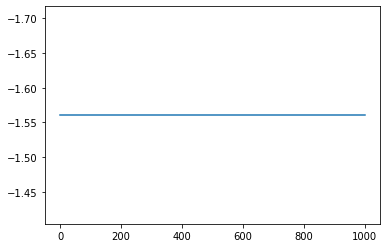

In [147]:
test = simple_electrodif(0, u=Initial_ko_x)
plt.plot(test)
plt.ylim((np.amin(test)-np.amin(test)*0.1),(np.amax(test)+np.amax(test)*0.1))
# print(test)

In [148]:
#@title Call the derivative taker
tout=np.linspace(0,nout,tf)

# out,infodict=odeint(pde4Sa,u0,tout,tfirst=True,full_output=True)
out_=solve_ivp(simple_electrodif,(0,tf),Initial_ko_x,t_eval=tout,vectorized=False,method='BDF', rtol=1e-6,atol=1e-6)

out=out_.y.T

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:328: RuntimeWarning: invalid value encountered in subtract
  diff = f_new - f[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:334: RuntimeWarning: invalid value encountered in less
  diff_too_small = max_diff < NUM_JAC_DIFF_REJECT * scale
/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: invalid value encountered in less
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/usr/local/lib/python3.6/dist-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: invalid value encountered in greater
  factor[max_diff > NUM_JAC_DIFF_BIG * scale] *= NUM_JAC_FACTOR_DECREASE


ValueError: ignored

ValueError: ignored

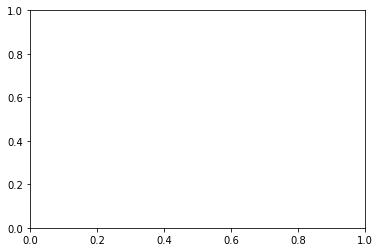

In [149]:
result, Ax = plt.subplots()
Ax.plot(x_dim,out.T, color="k")
Ax.plot(x_dim,out.T[:, nout - 1], color="g")
plt.show()

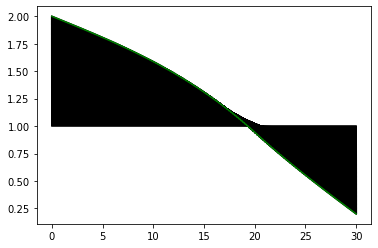

In [13]:
result, Ax = plt.subplots()
Ax.plot(x_dim,out.T, color="k")
Ax.plot(x_dim,out.T[:, nout - 1], color="g")
plt.show()

In [14]:
out_copy=out

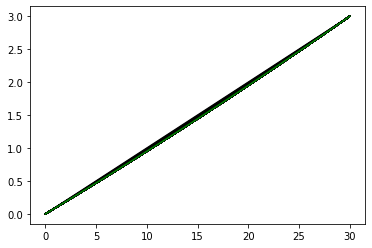

In [54]:
# #@title Older integrator

# call the integrator
# out: ndarray = np.zeros((t_steps, x_steps))
# print("shape of out: "+str(out.shape))

t_out = np.linspace(0, tf, nout)
out = odeint(simple_electrodif, Initial_ko_x, t_out, tfirst=True)
out=np.transpose(out)
# print("shape of out: "+str(odeint(simple_electrodif, Initial_Ko_x, t_out, tfirst=True).shape))

result, Ax = plt.subplots()
Ax.plot(x_dim,out, color="k")
Ax.plot(x_dim,out[:, nout - 1], color="g")
plt.show()


#To do
  -Fix problem with voltage gradient
  -Make video